# Black Friday Expense Predictor
  
### Description

The aim is to determine the amount of money an individual spends on Black Friday. The dataset we will be using is the Black Friday dataset provided by Kaggle.


### Authors
- Ruel Gordon
- Shumba Brown
- Kode Williams

Copyright © 2018. All Rights Reserved.

### Library Imports

In [0]:
import fnmatch
import math
import random

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
import seaborn as sns

# This line increases the amount of logging when there is an error.  You can
# remove it if you want less logging
tf.logging.set_verbosity(tf.logging.ERROR)

# Set the output display to have two digits for decimal places, for display
# readability only and limit it to printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 25

print ("Libraries loaded.")

# Dataset hosted here
# https://raw.githubusercontent.com/kodewilliams/blackfridaypredictor/master/BlackFriday.csv


Libraries loaded.


### Description of Dataset

The data contains 550,000 purchases by individuals from a multitude of demographics.

**Fields in the data include**:
* User ID
* Product ID
* Product Category
* Gender
* Age Range
* Occupation
* Category of city (A/B/C)
* Length of time in city
* Marital status

<br>    

**Feature Transformations**  

- We will have to perform numerous feature engineering procedures on the features
shown above. 

- Firstly we will have to do some data cleaning on age range and on the length of time in the city; currently they are represented as strings but we want to treat them numerically. Some features we will place in groups as either numerical or categorical for training purposes.

- We will also do one transformation on the purchase (which is our label and predicted value), we would like to represent the purchase value in bins or categories. For example, if someone spends 600 dollars that person might be spending in a "lower bin" but they spent 7000 they might be spending in a "higher bin"; we will also have bins or groups (middle low, middle high) in between.
 
<br>

**Visualization**

- We plan to make scatter plots after the data is sanitized and the features are transformed so we can see how the data looks in comparison to the label.

- We will also create calibration plots and ROC curves etc. to see how accurate the model is and will use histograms and other statistics graphs to determine what type of scaling to do.




In [0]:
COLUMNS = ["user_id", "product_id", "gender", "age", "occupation",
            "city_category", "stay_in_current_city_years", "marital_status", 
            "product_category_3", "purchase"]

url = "https://raw.githubusercontent.com/kodewilliams/blackfridaypredictor/master/BlackFriday.csv"
df = pd.read_csv(url, sep=",", low_memory=False)
df = df.reindex(np.random.permutation(df.index))
df.columns = map(str.lower, df.columns)

df = df[COLUMNS]
df.rename(index=str, columns={"stay_in_current_city_years": "city_years"}, inplace=True)
df.rename(index=str, columns={"product_category_3": "product_category"}, inplace=True)
df['product_category'] = pd.to_numeric(df['product_category'], errors='coerce')
df.user_id = df.user_id.astype(str)
df.occupation = df.occupation.astype(str)
df.marital_status = df.marital_status.astype(str)
df.product_category.fillna(0, inplace=True)
df.product_category = df.product_category.astype(str)

### Prepare Features

In [0]:
# Linearly rescales to the range [0, 1]
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = 1.0 * (max_val - min_val)
  return series.apply(lambda x:((x - min_val) / scale))

# Perform log scaling
def log_scale(series):
  return series.apply(lambda x:math.log(x+1.0))

# Clip all features to given min and max
def clip(series, clip_to_min, clip_to_max):
  # You need to modify this to actually do the clipping versus just returning
  # the series unchanged.
  return series.apply(lambda x: clip_to_min if x <= clip_to_min else (clip_to_max if x >= clip_to_max else x))

In [0]:
def prepare_features(dataframe):
  """Prepares the features for the provided dataset.

  Args:
    dataframe: A Pandas DataFrame containing the data set.
  Returns:
    A new DataFrame that contains the features to be used for the model.
  """
  processed_features = dataframe.copy()

  processed_features['purchase'] = clip(processed_features['purchase'], 0, 25000)
  processed_features['purchase'] = (processed_features['purchase'] / 1000.0)

  return processed_features

def prepare_targets(dataframe):
  """Prepares the targets for the provided dataset.

  Args:
    dataframe: A Pandas DataFrame containing the data set.
  Returns:
    A new DataFrame that contains the targets to be used for the model.
  """
  processed_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  processed_targets['purchase'] = (processed_targets['purchase'] / 1000.0)
  
  return processed_targets

### Split the data

In [0]:
n = len(df.index)
training = int((n * 0.25) // 1)
validation = int(((n * 0.05) // 1) + training)
test = int(n - validation)

# Assign 80% for training data
training_data = prepare_features(df.head(25000))

# Assign 10% for validation data
validation_data = prepare_features(df[25000:30000])

# Assign 10% for test data
test_data = prepare_features(df.tail(5000))

print ("Data split into training, validation and test sets.")

Data split into training, validation and test sets.


### Visualize the data

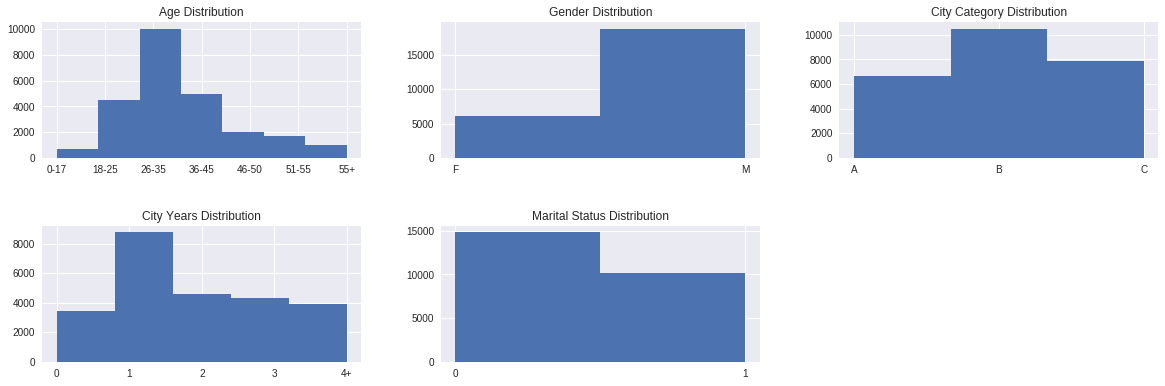

In [0]:
plt.figure(figsize=(20, 10))

# Visualize age
plt.subplot(3, 3, 1)
plt.title("Age Distribution")
histogram = training_data['age'].hist(bins=7)

# Visualize gender
plt.subplot(3, 3, 2)
plt.title("Gender Distribution")
histogram = training_data['gender'].hist(bins=2)

# Visualize city category
plt.subplot(3, 3, 3)
plt.title("City Category Distribution")
histogram = training_data['city_category'].hist(bins=3)

# Visualize city stay
plt.subplot(3, 3, 4)
plt.title("City Years Distribution")
histogram = training_data['city_years'].hist(bins=5)

# Visualize marital status
plt.subplot(3, 3, 5)
plt.title("Marital Status Distribution")
histogram = training_data['marital_status'].hist(bins=2)

plt.subplots_adjust(wspace=0.25, hspace=0.5)

In [0]:
def scatter_plot(features, targets, slopes=[], biases=[], model_names=[]):
  """ Creates a scatter plot of input_feature vs target along with the models.
  
  Args:
    features: list of the input features
    targets: list of targets
    slopes: list of model weight (slope) 
    bias: list of model bias (same size as slopes)
    model_names: list of model_names to use for legend (same size as slopes)
  """      
  # Define some colors to use that go from blue towards red
  colors = [cm.coolwarm(x) for x in np.linspace(0, 1, len(slopes))]
  
  # Generate the Scatter plot
  plt.ylabel("target")
  plt.xlabel("input feature")
  plt.scatter(features, targets, color='black', label="")
  # Add the lines corresponding to the provided models
  for i in range (0, len(slopes)):
    y_0 = slopes[i] * features.min() + biases[i]
    y_1 = slopes[i] * features.max() + biases[i]
    plt.plot([features.min(), features.max()], [y_0, y_1],
             label=model_names[i], color=colors[i])
  if (len(model_names) > 0):
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Loss and Input Functions

In [0]:
CATEGORICAL_FEATURES = ["user_id", "product_id", "age", "city_category", 
                        "gender", "occupation", "marital_status", 
                        "product_category"]
NUMERICAL_FEATURES = ["city_years"]
FEATURES = NUMERICAL_FEATURES+CATEGORICAL_FEATURES,
LABEL = "purchase"

def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Defines a function to preprocess the data, as well as how to batch,
      shuffle, and repeat it during model training.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
# Here we define an input functon that uses the training examples generating
# batches of 10 examples
training_input_fn = lambda: input_fn(
    training_examples[NUMERICAL_FEATURES], training_examples[LABEL], 
    batch_size=10)

# Here we define an input function that will compute the loss over the entire
# training set.
predict_training_input_fn = lambda: input_fn(
    training_examples[NUMERICAL_FEATURES], training_examples[LABEL], 
    num_epochs=1, shuffle=False)

# Here we define an input function that will compute the loss over the entire
# validation set.
predict_validation_input_fn = lambda: input_fn(
    validation_examples[NUMERICAL_FEATURES], validation_examples[LABEL], 
    num_epochs=1, shuffle=False)

In [0]:
def define_linear_regression_model(learning_rate):
  """ Defines a linear regression model of one feature to predict the target.
  
  Args:
    learning_rate: A `float`, the learning rate
    batch_size: A non-zero `int`, the batch size.
    
  Returns:
    A linear regressor created with the given parameters
  """
  
  optimizer=tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=construct_feature_columns(),
    optimizer=optimizer
  )  
  return linear_regressor

In [0]:
def compute_loss(predictions, targets):
  """ Computes the loss (RMSE) for linear regression.
  
  Args:
    predictions: a list of values predicted by the model being visualized
    targets: a list of the target values being predicted that must be the
             same size as predictions.
    
  Returns:
    The RMSE for the provided predictions and targets
  """      
  return math.sqrt(metrics.mean_squared_error(predictions, targets))

In [0]:
def plot_learning_curve(training_losses, validation_losses):
  """ Plot the learning curve.
  Args:
  training_loses: a list of losses to plot.
  validation_losses: a list of validation losses to plot.
  """       
  plt.ylabel('Loss')
  plt.xlabel('Training Steps')
  plt.plot(training_losses, label="Training Loss")
  plt.plot(validation_losses, label="Validation Loss")
  plt.legend(loc=1)

In [0]:
def calibration_plot(predictions, targets):
  """ Creates a calibration plot.
  
  Args:
    predictions: a list of values predicted by the model being visualized
    targets: a list of the target values being predicted that must be the
             same size as predictions.
  """  
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  calibration_data.describe()
  min_val = calibration_data["predictions"].min()
  max_val = calibration_data["predictions"].max()
  plt.ylabel("target")
  plt.xlabel("prediction")
  plt.scatter(predictions, targets, color='black')
  plt.plot([min_val, max_val], [min_val, max_val])

### Train Model

In [0]:
def train_model(linear_regressor, training_features, training_labels,
               validation_features, validation_labels, steps, batch_size):
 """Trains a linear regression model.
  Args:
   linear_regressor: The regressor to train
   training_features: The input features from the training data
   training_labels: the labels from the training data
   validatin_features: The input features from the validation data
   validation_labels: the labels from the validation data
   steps: A non-zero `int`, the total number of training steps.
   batch_size: A non-zero `int`, the batch size.
  
 Returns:
   The trained regressor
 """
 # In order to see how the model evolves as we train it, we will divide the
 # steps into periods and show the model after each period.
 periods = 10
 steps_per_period = steps / periods
  # Set up the training_input_fn, predict_training_input_fn, and
 # predict_validation_input_fn
 training_input_fn = lambda: input_fn(training_features, training_labels,
                                      batch_size=batch_size)
 predict_training_input_fn = lambda: input_fn(training_features,
                                              training_labels,
                                              num_epochs=1, shuffle=False)
 predict_validation_input_fn = lambda: input_fn(validation_features,
                                                validation_labels,
                                                num_epochs=1, shuffle=False)
  # Train the model, but do so inside a loop so that we can periodically assess
 # loss metrics.  We store the training losses to generate the training curve
 print("Training model...")
 training_losses = []
 validation_losses = []

 for period in range (0, periods):
   # Call fit to train the regressor for steps_per_period steps
   _ = linear_regressor.train(input_fn=training_input_fn, steps=steps_per_period)

   # Use the predict method to compute the training loss
   predictions_1 = linear_regressor.predict(input_fn=predict_training_input_fn)
   predictions_1 = np.array([item['predictions'][0] for item in predictions_1])
   training_loss = compute_loss(predictions_1, training_labels)
   training_losses.append(training_loss)
  
   # Use the predict method to compute the validation loss
   predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
   predictions = np.array([item['predictions'][0] for item in predictions])
   validation_loss = compute_loss(predictions, validation_labels)
   validation_losses.append(validation_loss)
   print("  Training loss, Validation loss after period %02d : %0.3f, %0.3f" % \
     (period, training_loss, validation_loss))
    
 # Now that training is done print the final training and validation loss   
 print("Final Loss (RMSE) on the training data: %0.3f" % training_loss)
 print("Final Loss (RMSE) on the validation data: %0.3f" % validation_loss)
  # Generate a figure with the learning curve on the left and a calibration
 # plot on the right.
 plt.figure(figsize=(10, 5))
 plt.subplot(1, 2, 1)
 plt.title("Learning Curve (RMSE vs time)")
 plot_learning_curve(training_losses, validation_losses)

 plt.subplot(1, 2, 2)
 plt.tight_layout(pad=1.1, w_pad=3.0, h_pad=3.0)
 plt.title("Calibration Plot on Validation Data")
 calibration_plot(predictions, validation_labels)
 
 return linear_regressor

In [0]:
# Create boundaries for age buckets
def construct_feature_columns():
  """Construct TensorFlow feature columns.
  
  Returns:
    A set of feature columns.
  """

  CATEGORICAL_FEATURES = ["user_id", "product_id", "gender", "occupation",
                          "marital_status", "product_category"]
  
  # Stores feature columns to be returned
  features = []
  # Create features with tensorflow API
  for feature in CATEGORICAL_FEATURES:
    features.append(
      tf.feature_column.categorical_column_with_vocabulary_list(
        key=feature, vocabulary_list = training_data[feature].unique())
    )
  
  return set(features)

Training model...
  Training loss, Validation loss after period 00 : 4.541, 4.428
  Training loss, Validation loss after period 01 : 4.365, 4.282
  Training loss, Validation loss after period 02 : 4.236, 4.190
  Training loss, Validation loss after period 03 : 4.080, 4.062
  Training loss, Validation loss after period 04 : 4.060, 4.094
  Training loss, Validation loss after period 05 : 3.932, 3.968
  Training loss, Validation loss after period 06 : 3.747, 3.805
  Training loss, Validation loss after period 07 : 3.621, 3.685
  Training loss, Validation loss after period 08 : 3.534, 3.647
  Training loss, Validation loss after period 09 : 3.535, 3.631
Final Loss (RMSE) on the training data: 3.535
Final Loss (RMSE) on the validation data: 3.631


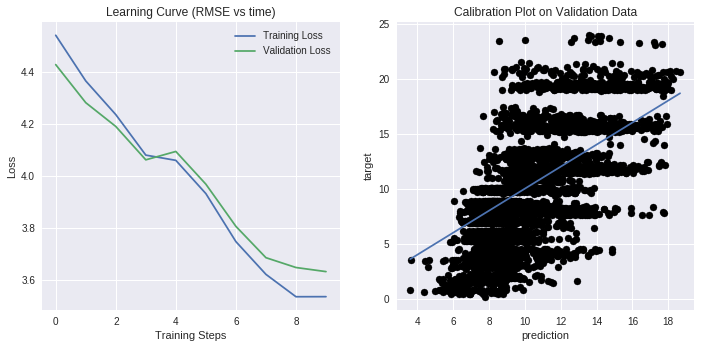

In [0]:
NUMERICAL_FEATURES = []
CATEGORICAL_FEATURES = ["user_id", "product_id", "gender", "occupation", 
                        "marital_status", "product_category"]
LABEL = "purchase"

LEARNING_RATE = 0.175
BATCH_SIZE = 100
STEPS = 1000

linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model(
    linear_regressor,
    training_data[NUMERICAL_FEATURES+CATEGORICAL_FEATURES],
    training_data[LABEL],
    validation_data[NUMERICAL_FEATURES+CATEGORICAL_FEATURES],
    validation_data[LABEL],
    batch_size=BATCH_SIZE, steps=STEPS)

In [0]:
# Here we define an input function that will compute the loss over the entire
# training set.
features = test_data[NUMERICAL_FEATURES+CATEGORICAL_FEATURES]
targets = test_data[LABEL]
predict_test_input_fn = lambda: input_fn(features, targets, num_epochs=1, shuffle=False)
test_losses = []
# Fill in the rest to complete this.
predictions = linear_regressor.predict(input_fn=predict_test_input_fn)
predictions = np.array([item['predictions'][0] for item in predictions])
test_loss = compute_loss(predictions, targets) #Find the loss by applying RMSE between our predictions and targets
test_losses.append(test_loss) #Append the loss calculated to an array
print("The loss measured from the test data is %0.3f" %(test_losses[0]))

The loss measured from the test data is 3.697


In [0]:
predictions = linear_regressor.predict(input_fn=predict_test_input_fn)
predictions = np.array([item['predictions'][0] for item in predictions])

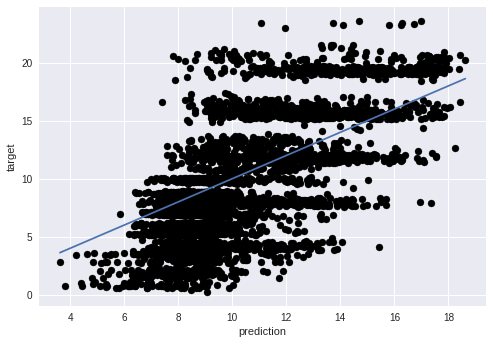

In [0]:
calibration_plot(predictions, test_data[LABEL])